In [1]:
import torch
from torch_geometric.nn import BatchNorm, PNAConv, global_add_pool
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
class BinaryClassBad(torch.nn.Module):
    def __init__(self, deg):
        super().__init__()

        aggregators = ['mean', 'min', 'max', 'std']
        scalers = ['identity', 'amplification', 'attenuation']

        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        for _ in range(2):
            conv = PNAConv(in_channels=5, out_channels=5,
                           aggregators=aggregators, scalers=scalers, deg=deg,
                           edge_dim=1, towers=5, pre_layers=1, post_layers=1,
                           divide_input=False)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(5))

        self.mlp = Sequential(Linear(5, 5), ReLU(), Linear(5, 10), ReLU(),
                              Linear(10, 1))

    def forward(self, x, edge_index, edge_attr, batch):
        x = x
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = F.relu(batch_norm(conv(x, edge_index, edge_attr)))

        x = global_add_pool(x, batch)
        return self.mlp(x)

/home/patrick/miniconda3/envs/tf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch_geometric.utils import degree
import torch

def degree_pna(dataset):
  max_degree = -1
  for data in dataset:
      d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
      max_degree = max(max_degree, int(d.max()))

  # Compute the in-degree histogram tensor
  deg = torch.zeros(max_degree + 1, dtype=torch.long)
  for data in dataset:
      d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
      deg += torch.bincount(d, minlength=deg.numel())
  return deg

In [3]:
import warnings
import numpy as np
warnings.filterwarnings("ignore")
torch.manual_seed(12345)
np.random.seed(1234)
from torch_geometric.loader.imbalanced_sampler import ImbalancedSampler

In [5]:
#dataset = torch.load("data/Detoxify5k_10.graph")
dataset = torch.load("data/Detoxify5k_5.graph")
#dataset = torch.load("data/Detoxify5k_15.graph")

In [7]:

split = int(len(dataset)*0.7)
train_dataset = dataset[:split]

remaining_dataset = dataset[split:]
remaining_split = int(len(remaining_dataset)*0.5)

validation_dataset = remaining_dataset[:remaining_split]
test_dataset = remaining_dataset[remaining_split:]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(validation_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
# Define the data loaders
train_loader = DataLoader(train_dataset,sampler=ImbalancedSampler(train_dataset), batch_size=64)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)
deg = degree_pna(train_dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BinaryClassBad(deg).to(device)

Number of training graphs: 3491
Number of validation graphs: 748
Number of test graphs: 749


In [8]:
m = torch.nn.Sigmoid()
loss_fn = torch.nn.BCEWithLogitsLoss()

In [9]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_auc_score, brier_score_loss, precision_score, recall_score

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay

0.010680907877169559
PR 0.027248418612049553
ROC 0.6467611336032388
BRIER 0.16041438370214164


Text(0.5, 1.0, 'Confusion matrix t = 0.75')

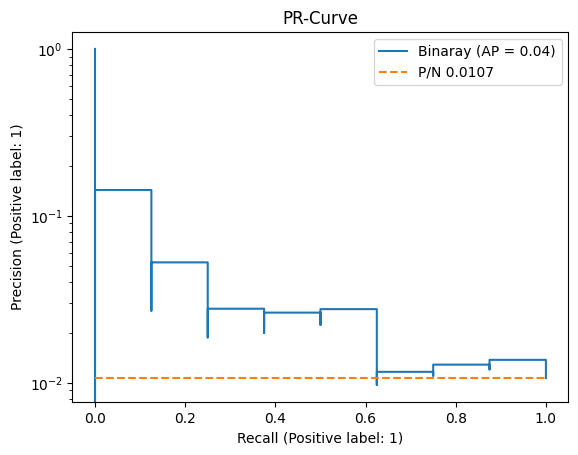

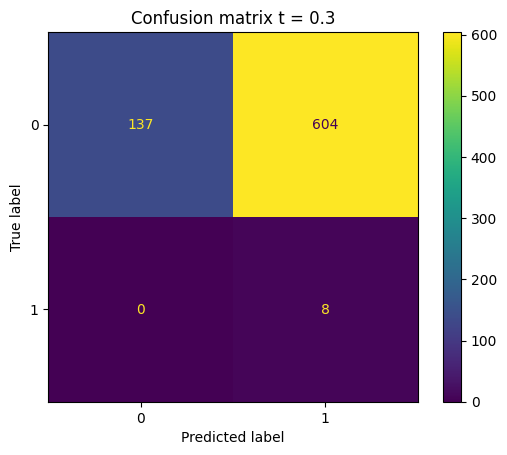

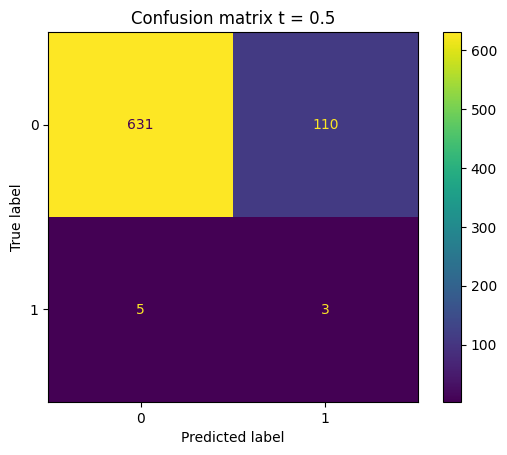

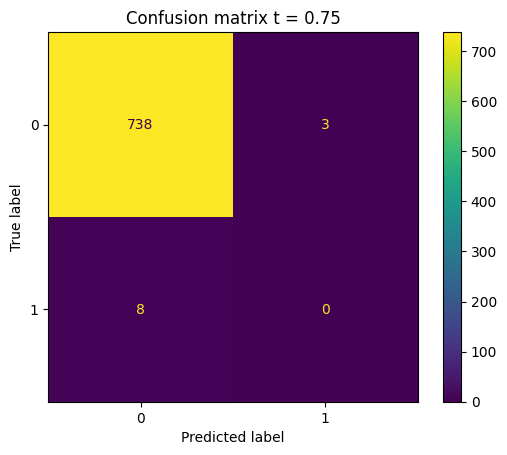

In [12]:


checkpoint_state = torch.load("data/Detoxify5k_5_checkpoint.pt")
model.load_state_dict(checkpoint_state)


model.eval()
total_error = 0
y_true = []
y_score = []
for data in test_loader:
    data = data.to(device)
    out = model(data.x, data.edge_index, data.edge_attr, data.batch)
    pred = m(out.squeeze()) 
    total_error += loss_fn(out.squeeze(), data.y.to(torch.float32)).item() * data.num_graphs
    y_true.extend(data.y.tolist())
    y_score.extend(pred.tolist())
        
y_true = np.array(y_true)
y_score = np.array(y_score)

display = PrecisionRecallDisplay.from_predictions(
    y_true, y_score, name="Binaray"
)

no_skill = (y_true == 1).sum() / len(y_true)
print(no_skill)
plt.title("PR-Curve")
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'P/N {no_skill:.4f}')
plt.legend()
plt.yscale('log')

#pr_base = (y_true == 1).sum() / len(y_true)
acc = (torch.tensor(y_true > 0.5) == torch.tensor(y_score > 0.5)).sum() / len(y_score)
precision, recall, thresholds = precision_recall_curve(y_true, y_score)
print("PR",  auc(recall, precision))
print("ROC", roc_auc_score(y_true, y_score)) 
print("BRIER", brier_score_loss(y_true, y_score)) 

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_score > 0.3))

disp.plot()
plt.title("Confusion matrix t = 0.3")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_score > 0.5))

disp.plot()
plt.title("Confusion matrix t = 0.5")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_score > 0.75))

disp.plot()
plt.title("Confusion matrix t = 0.75")
#return total_error / len(loader.dataset), roc_score, acc, brier_score, pr_auc_score, pr_base
#Test: 0.4524, ROC: 0.7483, ACC: 0.8080, PR_AUC: 0.0275, PR_BASE: 0.0107 BRIER: 0.1407 